# Lab 4

Ganti constant `STATIC` menjadi path ke gambar-gambar yang akan digunakan dan `OUT` menjadi path ke output directory. Contoh jika gambar ada di directory yang sama dengan script ini, maka value nya menjadi `"."`. Library yang dibutuhkan untuk menjalankan script ini adalah sebagai berikut: `scikit-image`, `matplotlib`, `numpy`, `opencv`, dan `ipympl`. Cara menjalankan scriptnya sama seperti menjalankan notebook biasa.

In [1]:
import functools, os
from pathlib import Path

SUB = "lab5"
BASE_DIR = Path(os.path.abspath("")).resolve(strict=True).parent
OUT = os.path.join(BASE_DIR, "out", SUB)
STATIC = os.path.join(BASE_DIR, "static", SUB)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage import color, filters, io, util
from skimage.segmentation import mark_boundaries, slic

# %matplotlib widget

In [3]:
def help_fig(col, row, titles, images, dpi=100.0):
    fig, axs = plt.subplots(col, row, dpi=dpi)
    if col > 1 or row > 1:
        for i, ax in enumerate(axs.flatten()):
            ax.set_title(titles[i])
            ax.imshow(images[i], cmap="gray")
            ax.set_axis_off()
    else:
        axs.set_title(titles[0])
        axs.imshow(images[0], cmap="gray")
        axs.set_axis_off()
    fig.tight_layout()
    plt.show()

## Thresholding

In [4]:
tools = color.rgb2gray(io.imread(os.path.join(STATIC, "tools.jpg")))

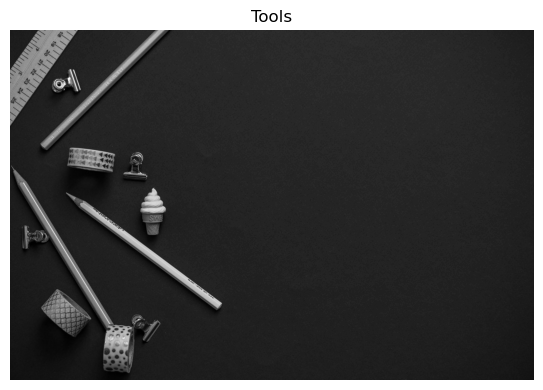

In [5]:
help_fig(1, 1, ["Tools"], [tools])

### Simple Global Thresholding

In [6]:
_, tools_simple = cv2.threshold(util.img_as_ubyte(tools), 127, 255, cv2.THRESH_BINARY)

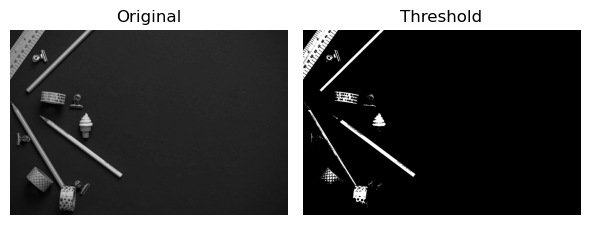

In [7]:
help_fig(1, 2, ["Original", "Threshold"], [tools, tools_simple])

### Otsu's Thresholding

In [8]:
tools_otsu_g = util.img_as_ubyte(tools)
tools_otsu_t = filters.threshold_otsu(tools_otsu_g)
tools_otsu = util.img_as_float(tools_otsu_g > tools_otsu_t)

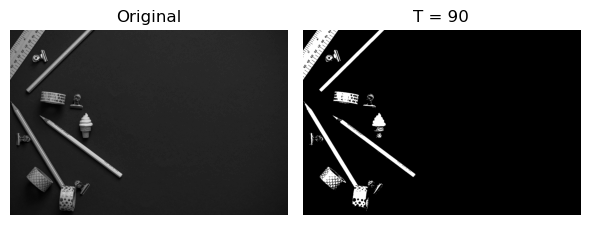

In [9]:
help_fig(1, 2, ["Original", f"T = {tools_otsu_t}"], [tools, tools_otsu])

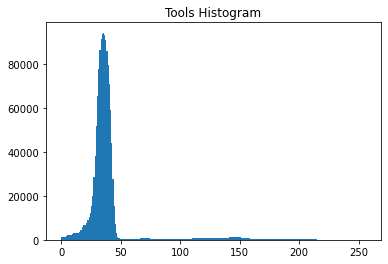

In [10]:
tools_histogram = util.img_as_ubyte(tools)
fig, ax = plt.subplots(1, 1)
ax.hist(tools_histogram.flatten(), 256, range=(0, 256))
ax.set_title("Tools Histogram")
fig.show()

### Differences

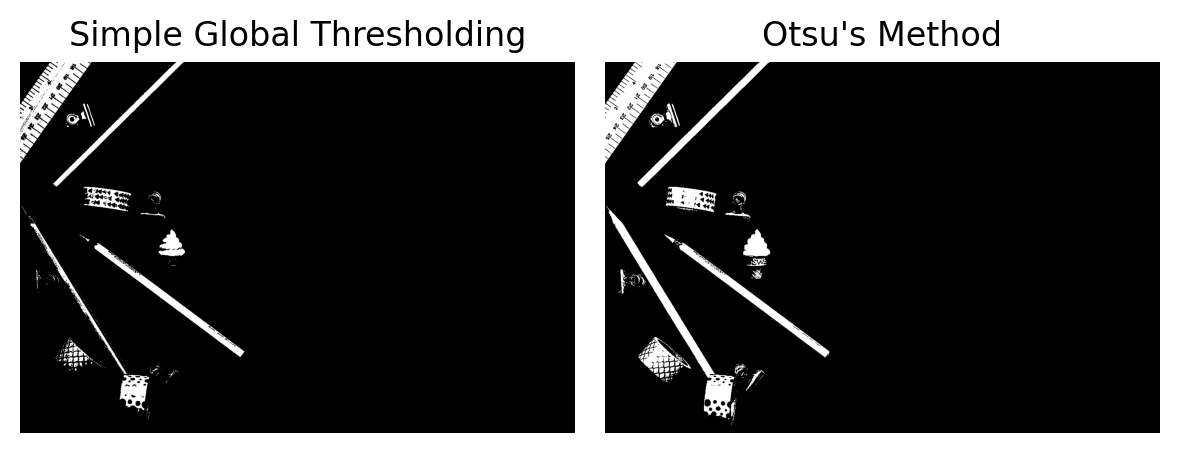

In [11]:
help_fig(1, 2, ["Simple Global Thresholding", "Otsu's Method"], [tools_simple, tools_otsu], 200)

Bisa dilihat perbedaan hasil thresholding, contohnya di cincin bawah kiri. Hal ini bisa terjadi karena perbedaan dari threshold yang dipakai kedua cara tersebut. Untuk simple global thresholding, saya menggunakan value asal-asalan, sedangkat Otsu's method menggunakan threshold sebesar 90. Angka 90 tersebut adalah hasil perhitungan mencari intra-class variance yang rendah. Jadi bisa dibliang simple global thresholding itu cara naive. Kita bisa mendapat hasil simple global thresholding yang sama dengan Otsu's method dengan cara tuning value nya sampai mendapat hasil yang diinginkan.

### Optimal Method

Otsu's method lebih baik jika ingin mendapat value yang baik secara cepat, tetapi simple global thresholding bisa menghasilkan threshold yang lebih baik jika dilakukan tuning ke threshold nya. Kita bisa menggabungkan kedua cara tersebut dengan cara melakukan Otsu's method pertama untuk mendapat initial value yang baik, lalu melakukan tuning ke threshold tersebut dan menghasilkan threshold yang lebi bagus.

## Clustering

In [12]:
mt = io.imread(os.path.join(STATIC, "mountain.jpg"))

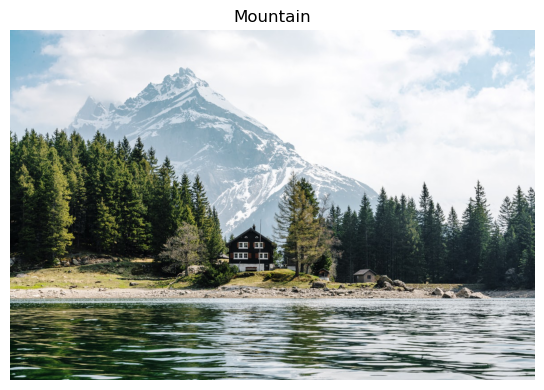

In [13]:
help_fig(1, 1, ["Mountain"], [mt])

### SLIC

In [14]:
N_SEGMENTS = [10, 50, 100]
mt_slics = list(map(lambda n: slic(mt, n_segments=n, compactness=10, sigma=1, start_label=0), N_SEGMENTS))

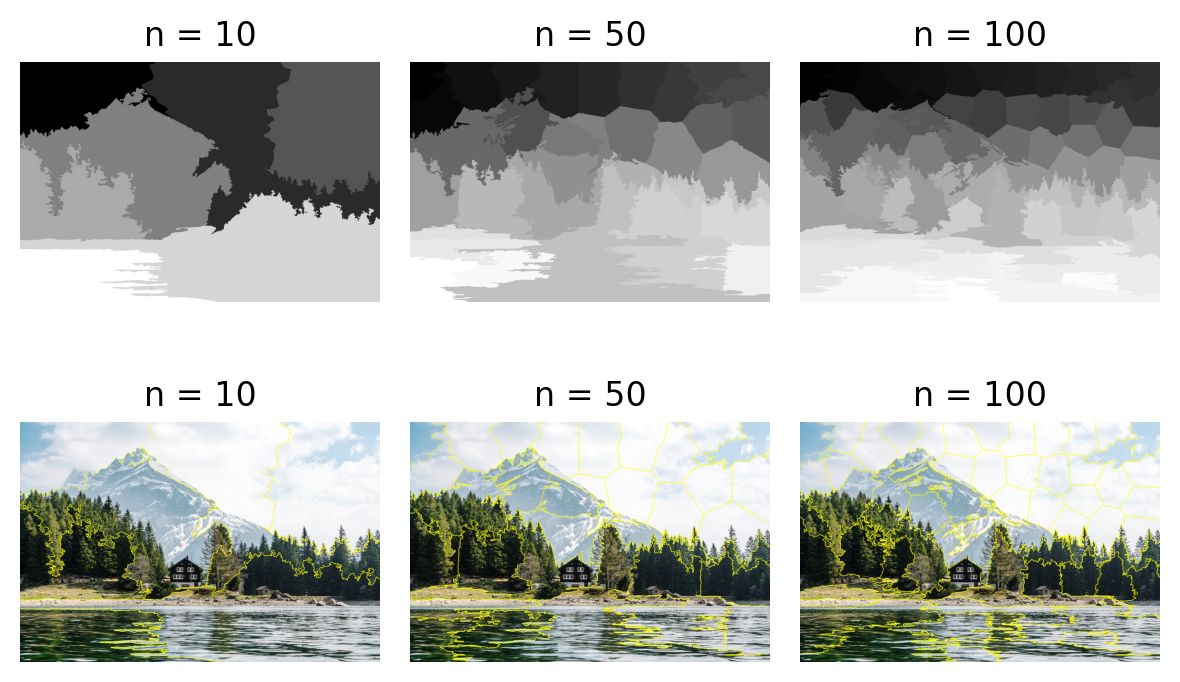

In [15]:
help_fig(2, 3, [*list(map(lambda n: f"n = {n}", N_SEGMENTS)), *list(map(lambda n: f"n = {n}", N_SEGMENTS))], [*mt_slics, *list(map(lambda segment: mark_boundaries(mt, segment), mt_slics))], 200)

### Takeaway

Takeaway pertama yang kita bisa dapat dari hasil segmentasi adalah jumlah region dari setipa slics, tentu dipengaruhi oleh variable `n_segments`. Semakin banyak jumlah segmentasinya, semakin kecil dan detail hasil segmentasi nya, kita bisa lihat di area pohon kanan, semakin banyak jumlah segmen nya, semakin banyak juga segmen pohon di hasilnya.

Tidaka ada gambar yang salah, tapi menurut saya, segmentasi yang paling bagus adalah gambar ketiga dengan `n_segments = 100`. Gambar asli tidak memiliki edges yang jelas, contohnya pohon kiri di antara hutan dengan langit baru bisa di segmentasi dengan jumlah segments 100, tetapi di dalam hutan nya sendiri tersegment dari awal (di bagian hutan gelap vs terang). Lalu yang paling saya suka adalah segmentasi rumah paling bagus dihasilkan dengan jumlah segment 100.

### Visualization

In [16]:
CHOOSEN_SLIC = 2

def superpixel_mean_image(image, slic_labels):
    """
    Code taken from https://stackoverflow.com/a/57746835
    Turn image into superpixel image, given SLIC segment
    labels.
    
    Modified by Ilman.
    """
    im_rp = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))
    sli_1d = np.reshape(slic_labels, -1)
    uni = np.unique(sli_1d)
    new_img = np.zeros(im_rp.shape)
    for i in uni:
        loc = np.where(sli_1d == i)[0]
        #print(loc)
        mm = np.median(im_rp[loc, :], axis=0)
        new_img[loc, :] = mm
    return np.reshape(new_img, [image.shape[0], image.shape[1], image.shape[2]]).astype('uint8')
mt_median = superpixel_mean_image(mt, mt_slics[CHOOSEN_SLIC])

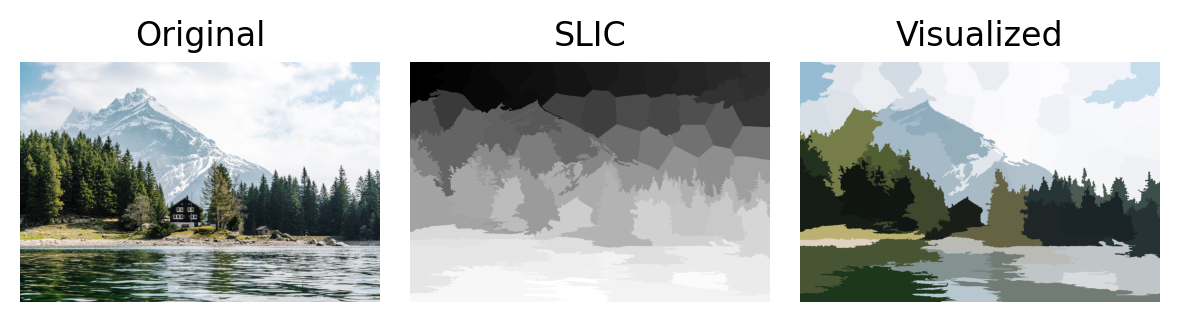

In [17]:
help_fig(1, 3, ["Original", "SLIC", "Visualized"], [mt, mt_slics[CHOOSEN_SLIC], mt_median], 200)